# Learning metrics

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from one.api import ONE
import concurrent.futures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# Get my functions
from functions import create_grouped_gradient_palette

one = ONE(mode='remote')

In [3]:
# Get my functions
def idxs_from_files(design_matrices):
    
    idxs = []
    mouse_names = []
    for m, mat in enumerate(design_matrices):
        mouse_name = design_matrices[m][51:]
        eid = design_matrices[m][14:50]
        idx = str(eid + '_' + mouse_name)

        if len(idxs) == 0:
            idxs = idx
            mouse_names = mouse_name
        else:
            idxs = np.hstack((idxs, idx))
            mouse_names = np.hstack((mouse_names, mouse_name))
            
    return idxs, mouse_names


""" 
LOAD DATA AND PARAMETERS
"""
# LOAD DATA

data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

learning_data_path =   prefix + 'representation_learning_variability/paper-individuality/data/training_data/'


In [4]:
all_files = os.listdir(learning_data_path)
training_mice = []

for m, mouse_name in enumerate(np.unique(mouse_names)):
    
    filename = 'training_data_trials_'+mouse_name
    if filename in all_files:
        training_mice.append(mouse_name)
    
print(len(training_mice))

70


# Compute training metrics

In [5]:
def get_types(mouse_data):
    mouse_data.loc[mouse_data['feedbackType']==-1, 'feedbackType'] = 0 
    mouse_data['contrast'] = mouse_data['contrastLeft'].fillna(0) + mouse_data['contrastRight'].fillna(0)
    mouse_data['correct_easy'] = mouse_data['feedbackType'] * np.nan

    mouse_data.loc[(mouse_data['feedbackType']==1) & 
                (mouse_data['contrast']>=.5), 'correct_easy'] = 1
    mouse_data.loc[(mouse_data['feedbackType']==0) & 
                (mouse_data['contrast']>=.5), 'correct_easy'] = 0

    session_data = mouse_data.groupby(['session_date', 'session'])['correct_easy'].mean().rename("performance_easy").reset_index().sort_values(by='session_date')

    session_data['type'] = session_data['performance_easy'] * np.nan
    session_data.loc[session_data['performance_easy']<.4, 'type'] = 0
    session_data.loc[(session_data['performance_easy']>.4), 'type'] = 1
    session_data.loc[(session_data['performance_easy']>.7), 'type'] = 2
    # session_data.loc[(session_data['performance_easy']>.8), 'type'] = 3
    
    return session_data

In [6]:
def prepro(trials):

    """ Performance """
    # Some preprocessing
    trials['contrastLeft'] = trials['contrastLeft'].fillna(0)
    trials['contrastRight'] = trials['contrastRight'].fillna(0)
    trials['signed_contrast'] = - trials['contrastLeft'] + trials['contrastRight']
    trials['contrast'] = trials['contrastLeft'] + trials['contrastRight']
    trials['side'] = np.sign(trials['signed_contrast'])
    trials['correct_easy'] = trials['feedbackType']
    trials.loc[trials['correct_easy']==-1, 'correct_easy'] = 0
    trials['correct'] = trials['feedbackType']
    trials.loc[trials['contrast']<.5, 'correct_easy'] = np.nan
    trials.loc[trials['correct']==-1, 'correct'] = 0

    """ Response/ reaction times """
    trials['response'] = trials['response_times'] - trials['goCue_times']
    trials['reaction'] = trials['firstMovement_times'] - trials['goCue_times']
    """ Quiescence elongation """
    if 'quiescencePeriod' in trials.keys():
        trials['elongation'] = trials['goCue_times'] - trials['quiescencePeriod'] - trials['intervals_0']
    elif 'quiescence' in trials.keys():
        trials['elongation'] = trials['goCue_times'] - trials['quiescence'] - trials['intervals_0']
    else:
        print('cannot compute elongation')
        
    """ Win stay lose shift """
    trials['prev_choice'] = trials['choice'] * np.nan
    trials['prev_choice'][1:] = trials['choice'][:-1]
    trials['prev_feedback'] = trials['feedbackType'] * np.nan
    trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
    trials['wsls'] = trials['choice'] * np.nan
    trials.loc[(trials['prev_feedback']==1.) & (trials['choice']==trials['prev_choice']), 'wsls'] = 'wst'
    trials.loc[(trials['prev_feedback']==1.) & (trials['choice']!=trials['prev_choice']), 'wsls'] = 'wsh'
    trials.loc[(trials['prev_feedback']==-1.) & (trials['choice']!=trials['prev_choice']), 'wsls'] = 'lsh'
    trials.loc[(trials['prev_feedback']==-1.) & (trials['choice']==trials['prev_choice']), 'wsls'] = 'lst'
    #TODO : trials['days_to_trained'] = trials['training_time']

    return trials

In [7]:
training_times = pd.DataFrame(columns=['mouse_name', 'training_days', 'training_trials', 'time_span'], index=range(len(training_mice)))

for m, mouse_name in enumerate(training_mice):

    # Trials data
    mouse_data = pd.read_parquet(learning_data_path+'training_data_trials_'+mouse_name).drop_duplicates()

    # Save
    training_times['mouse_name'][m] = mouse_name
    training_times['training_days'][m] = len(mouse_data.session_date.unique())
    training_times['training_trials'][m] = len(mouse_data)
    training_times['time_span'][m] = (mouse_data.session_date.max() - mouse_data.session_date.min()).days
    

/tmp/ipykernel_7959/3130758878.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  training_times['mouse_name'][m] = mouse_name
/tmp/ipykernel_7959/3130758878.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!

In [8]:
all_mice = pd.DataFrame()
bin_num = 15
for m, mouse_name in enumerate(training_mice):
    
    # Trials data
    mouse_data = pd.read_parquet(learning_data_path+'training_data_trials_'+mouse_name)
    mouse_data = mouse_data.sort_values(by=['session_start_time', 'intervals_0']).drop_duplicates().reset_index()
    mouse_data['training_day'] = pd.factorize(mouse_data['session_date'])[0] + 1
    mouse_df = prepro(mouse_data)
    mouse_df['mouse_name'] = mouse_name
    
    session_bias = (mouse_data.groupby(['session_date', 'session'])
                                .apply(lambda x: ((x["choice"] == -1).sum() - (x["choice"] == 1).sum())/ ((x["choice"] == -1).sum() + (x["choice"] == 1).sum()))
                                .rename("bias")
                            ).reset_index()
    session_count = (mouse_data.groupby(['session_date', 'session'])
                                .apply(lambda x: len(x["choice"]))
                                .rename("trial_count")
                            ).reset_index()
    mouse_df = mouse_df.merge(session_bias, on=['session_date', 'session'])
    mouse_df = mouse_df.merge(session_count, on=['session_date', 'session'])

    # Caltulate bin specifics
    total_trials = len(mouse_df)
    bin_size = int(np.round(total_trials / bin_num))
    bin_index = np.array([])
    # Design bin number array
    for n in range(bin_num):
        this_bin_index = np.ones(bin_size) * (n+1)
        this_bin_index[500:] = np.nan
        bin_index = np.concatenate((bin_index, this_bin_index), axis=None)
    # Add buffer to the end in case array is shorter than dataframe
    bin_index = np.concatenate((bin_index, np.ones(bin_size) * bin_num), axis=None)
    # plt.plot(bin_index)
    # plt.show()
    mouse_df['bin_frac'] = bin_index[0:len(mouse_df)]
    
    summary_df = mouse_df.groupby(['mouse_name', 'bin_frac'])[['correct_easy', 'bias', 'reaction', 'response', 'elongation', 'trial_count']].mean().reset_index()
    
    # Append subject data to big dataframe
    all_mice = pd.concat((all_mice, summary_df))
all_mice = all_mice.merge(training_times, on=['mouse_name'])


/tmp/ipykernel_7959/2669374660.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/tmp/ipykernel_7959/2669374660.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [9]:
all_mice = all_mice.dropna()

In [10]:
X_data = np.array(all_mice[['correct_easy', 'bias', 'response', 'elongation', 'trial_count']])

# PCA

In [11]:
n_components = 5
# use_data = np.array(df1)[:, 1:]
use_data = X_data
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
standardized_X = scaler.fit_transform(use_data)
X_pca = pca.fit_transform(standardized_X)
# X_pca = pca.fit_transform(use_data)


Text(0.5, 1.0, 'Explained Variance by PCA')

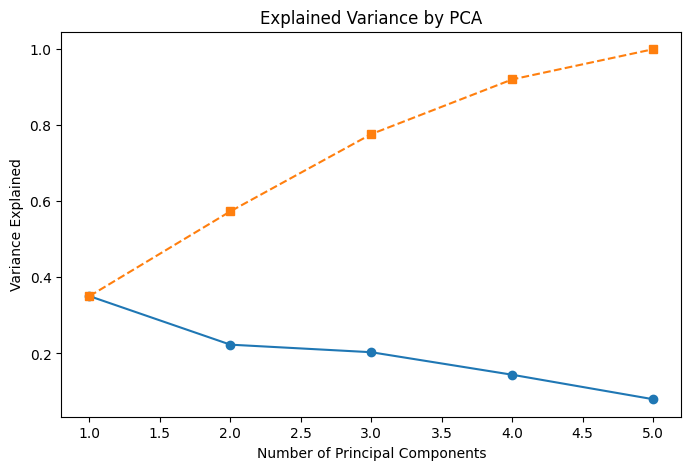

In [12]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

In [13]:
quantiles = all_mice[['mouse_name', 'training_days']].drop_duplicates()['training_days'].quantile([.25, .5, .75])
all_mice['quantile'] = all_mice['training_days'] * np.nan
all_mice.loc[all_mice['training_days'] <= quantiles[0.25], 'quantile'] = 1
all_mice.loc[(all_mice['training_days'] > quantiles[0.25]) &
                (all_mice['training_days'] <= quantiles[0.5]), 'quantile'] = 2
all_mice.loc[(all_mice['training_days'] > quantiles[0.5]) &
                (all_mice['training_days'] <= quantiles[0.75]), 'quantile'] = 3
all_mice.loc[all_mice['training_days'] > quantiles[0.75], 'quantile'] = 4

In [307]:

all_mice['pc1'] = X_pca[:, 0]
all_mice['pc2'] = X_pca[:, 1]
all_mice['pc3'] = X_pca[:, 2]
all_mice['pc4'] = X_pca[:, 3]
all_mice['pc5'] = X_pca[:, 4]


ValueError: Length of values (420) does not match length of index (700)

## Learning quartiles

In [154]:
merged_df = all_mice.copy()
shuffled = merged_df[['mouse_name', 'quantile']].drop_duplicates().reset_index()
shuffled['shuffle'] =  np.random.permutation(shuffled['quantile'].values)
merged_df = merged_df.merge(shuffled[['mouse_name', 'shuffle']], on='mouse_name')

In [155]:
a = merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()

fig = go.Figure()

for cluster, df  in a.groupby(["shuffle"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
    ))

fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
    ),
    legend_title_text="shuffle"
)

fig.show()

In [156]:
a = merged_df.groupby(["quantile", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["quantile", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()
# Example: using your dataframe 'all_mice'
fig = go.Figure()

for cluster, df  in a.groupby(["quantile"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
    ))

fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
    ),
    legend_title_text="quantile"
)

fig.show()

# Per mice

In [178]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
cluster_df = pd.read_parquet(data_path+'5_cluster_per_mice')

In [166]:
merged_df = all_mice.merge(cluster_df, on='mouse_name')
# merged_df = merged_df.loc[merged_df['mouse_cluster'].isin([0, 2, 4])]
shuffled = merged_df[['mouse_name', 'mouse_cluster']].drop_duplicates().reset_index()
shuffled['shuffle'] =  np.random.permutation(shuffled['mouse_cluster'].values)
merged_df = merged_df.merge(shuffled[['mouse_name', 'shuffle']])


(array([340.,   0.,  50.,   0.,   0., 130.,   0.,  50.,   0., 130.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

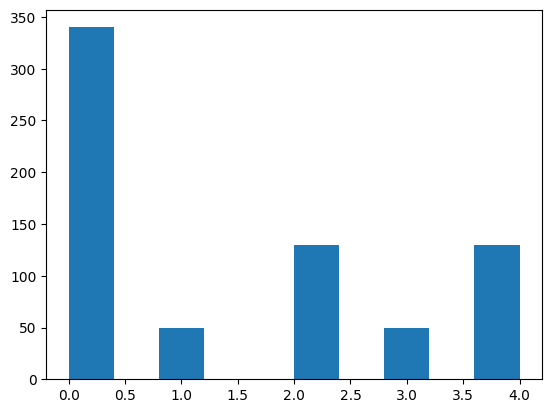

In [167]:
plt.hist(merged_df.mouse_cluster)

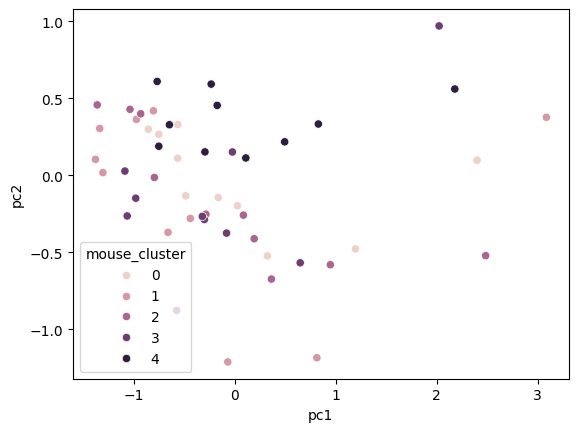

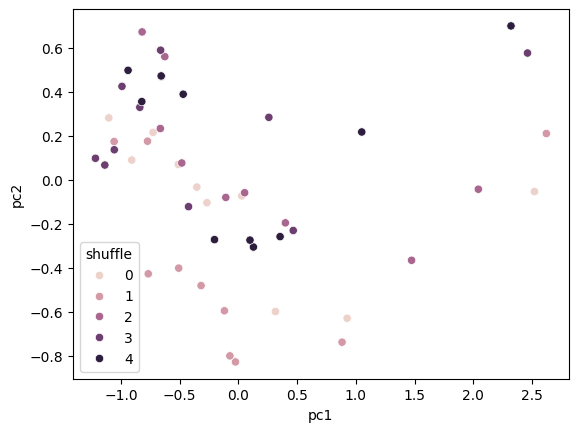

In [169]:
pc_avg = merged_df.groupby(['mouse_cluster', 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean().reset_index()
sns.scatterplot(x='pc1', y='pc2', hue='mouse_cluster', data=pc_avg)
plt.show()

pc_avg = merged_df.groupby(['shuffle', 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean().reset_index()
sns.scatterplot(x='pc1', y='pc2', hue='shuffle', data=pc_avg)
plt.show()

In [170]:
a = merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()
# Example: using your dataframe 'all_mice'
fig = go.Figure()

for cluster, df  in a.groupby(["shuffle"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
))
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC4",
    ),
    legend_title_text="shuffle"
)

fig.show()

In [163]:
a = merged_df.groupby(["mouse_cluster", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["mouse_cluster", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()
# Example: using your dataframe 'all_mice'
fig = go.Figure()

for cluster, df  in a.groupby(["mouse_cluster"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
    ))

fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC4",
    ),
    legend_title_text="mouse_cluster"
)

fig.show()


# Per session

In [112]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
cluster_df = pd.read_parquet(data_path+'3_cluster_per_session_kmeans')
cluster_df = pd.read_parquet(data_path+'cluster_per_session')

In [113]:
clusters = cluster_df.groupby(['mouse_name'])['session_cluster'].std().reset_index()
clusters.loc[clusters['session_cluster'].isna(), 'session_cluster'] = 0
merged_df = all_mice.merge(clusters, on='mouse_name')
# all_mice = all_mice.merge(cluster_df['mouse_name'], on='mouse_name')


In [114]:
merged_df = merged_df.loc[merged_df['session_cluster']==0]
merged_df = merged_df.drop(columns='session_cluster')

In [115]:
merged_df = merged_df.merge(cluster_df[['mouse_name', 'session_cluster']], on='mouse_name')

In [116]:
shuffled = merged_df[['mouse_name', 'session_cluster']].drop_duplicates().reset_index()

shuffled['shuffle'] =  np.random.permutation(shuffled['session_cluster'].values)
merged_df = merged_df.merge(shuffled[['mouse_name', 'shuffle']])

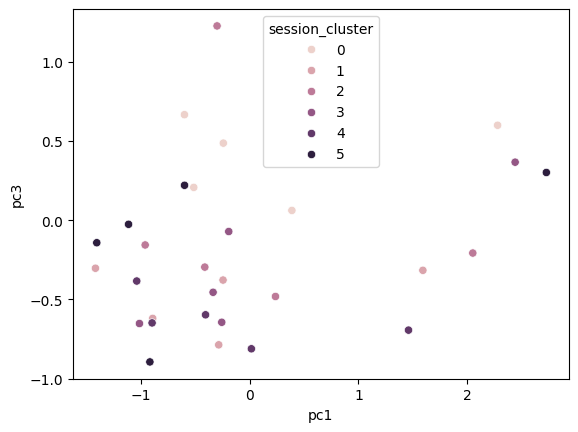

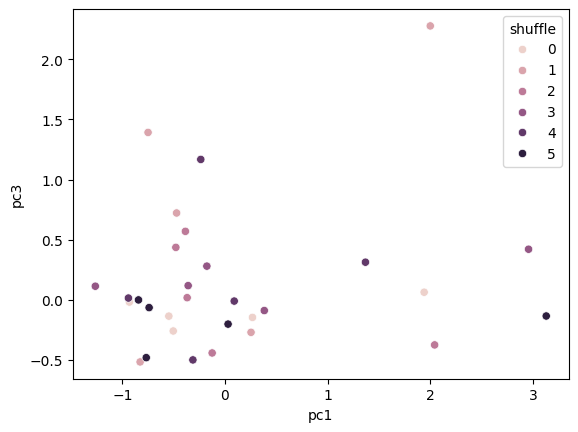

In [117]:
pc_avg = merged_df.groupby(['session_cluster', 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean().reset_index()
sns.scatterplot(x='pc1', y='pc3', hue='session_cluster', data=pc_avg)
plt.show()

pc_avg = merged_df.groupby(['shuffle', 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean().reset_index()
sns.scatterplot(x='pc1', y='pc3', hue='shuffle', data=pc_avg)
plt.show()

In [118]:
a = merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()
# Example: using your dataframe 'all_mice'
fig = go.Figure()

for cluster, df  in a.groupby(["shuffle"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
))
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC4",
    ),
    legend_title_text="shuffle"
)

fig.show()

In [119]:
a = merged_df.groupby(["session_cluster", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["session_cluster", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()
# Example: using your dataframe 'all_mice'
fig = go.Figure()

for cluster, df  in a.groupby(["session_cluster"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
    ))

fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC4",
    ),
    legend_title_text="session_cluster"
)

fig.show()


# Sankey plot

In [439]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
mouse_cluster = pd.read_parquet(data_path+'5_cluster_per_mice')
session_cluster = pd.read_parquet(data_path+'cluster_per_session')
sankey_df = session_cluster[['mouse_name', 'session_cluster', 'session']].merge(mouse_cluster[['mouse_name', 'mouse_cluster']], on='mouse_name')


In [440]:
from collections import Counter

mouse_stats = []

for mouse, dfm in sankey_df.groupby('mouse_name'):
    clusters = dfm['session_cluster'].tolist()
    dom = Counter(clusters).most_common(1)[0][0]
    consistency = clusters.count(dom) / len(clusters)
    mouse_stats.append((mouse, dom, consistency))

mouse_df = pd.DataFrame(mouse_stats, columns=['mouse_name', 'dominant_cluster', 'consistency'])
print(mouse_df)
mouse_df.loc[mouse_df['consistency']<=.5, 'dominant_cluster'] = 6
sankey_df = sankey_df.merge(mouse_df[['mouse_name', 'dominant_cluster']], on='mouse_name')

       mouse_name  dominant_cluster  consistency
0     CSH_ZAD_019                 1     0.500000
1     CSH_ZAD_026                 4     0.666667
2     CSH_ZAD_029                 2     1.000000
3          DY_016                 4     1.000000
4          DY_018                 4     1.000000
..            ...               ...          ...
65  ibl_witten_25                 0     1.000000
66  ibl_witten_26                 3     0.500000
67  ibl_witten_27                 0     0.333333
68  ibl_witten_29                 2     0.777778
69  ibl_witten_32                 3     1.000000

[70 rows x 3 columns]


In [447]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
sankey_df.to_parquet(data_path+'dominant_mouse_cluster')

In [446]:
sankey_df.dominant_cluster.unique()

array([6, 4, 2, 0, 3, 5, 1])

In [410]:
# --- 1. GROUP DATA ---
# df must contain: session_cluster, mouse_cluster
counts = sankey_df.groupby(['session_cluster', 'dominant_cluster']).size().reset_index(name='value')

# --- 2. BUILD NODE LABELS ---
session_labels = sorted(counts['session_cluster'].unique())
mouse_labels   = sorted(counts['dominant_cluster'].unique())
labels = session_labels + mouse_labels
# mapping session nodes 0..len(session_labels)-1
session_index = {s: i for i, s in enumerate(session_labels)}
# mapping mouse nodes after sessions
mouse_index = {m: i + len(session_labels) for i, m in enumerate(mouse_labels)}

# --- 3. BUILD LINKS ---
sources = []
targets = []
values  = []
for _, row in counts.iterrows():
    s = session_index[row['session_cluster']]
    t = mouse_index[row['dominant_cluster']]
    v = row['value']
    sources.append(s)
    targets.append(t)
    values.append(v)

# --- 4. PLOT SANKEY ---
fig = go.Figure(go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        label=labels,
        line=dict(color="black", width=0.5)),
    link=dict(
        source=sources,
        target=targets,
        value=values)))

fig.update_layout(title_text="Session → Mouse Behavioral Cluster Flow", font_size=14)
fig.show()


# Per dominant cluster

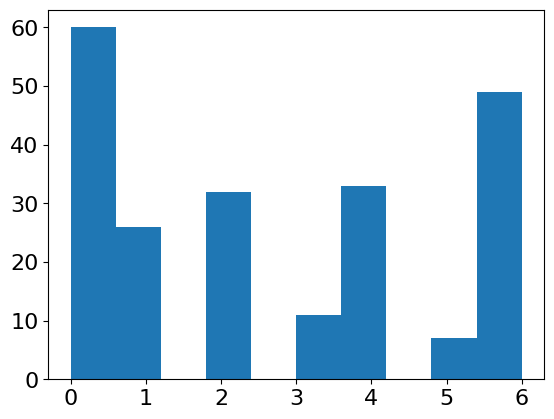

In [411]:
plt.hist(sankey_df.dominant_cluster)
sankey_df = sankey_df.loc[sankey_df['dominant_cluster'].isin([0, 1, 2, 4, 6])]
# plt.hist(sankey_df.dominant_cluster)


In [353]:
clusters = cluster_df.groupby(['mouse_name'])['session_cluster'].std().reset_index()
clusters.loc[clusters['session_cluster'].isna(), 'session_cluster'] = 0
merged_df = all_mice.merge(sankey_df[['mouse_name', 'dominant_cluster']], on='mouse_name')
# all_mice = all_mice.merge(cluster_df['mouse_name'], on='mouse_name')


In [354]:
shuffled = merged_df[['mouse_name', 'dominant_cluster']].drop_duplicates().reset_index()

shuffled['shuffle'] =  np.random.permutation(shuffled['dominant_cluster'].values)
merged_df = merged_df.merge(shuffled[['mouse_name', 'shuffle']])

In [355]:
pc_avg = merged_df.groupby(['dominant_cluster', 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean().reset_index()
sns.scatterplot(x='pc1', y='pc2', hue='dominant_cluster', data=pc_avg)
plt.show()

pc_avg = merged_df.groupby(['shuffle', 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean().reset_index()
sns.scatterplot(x='pc1', y='pc2', hue='shuffle', data=pc_avg)
plt.show()

KeyError: "Columns not found: 'pc4', 'pc1', 'pc2', 'pc3'"

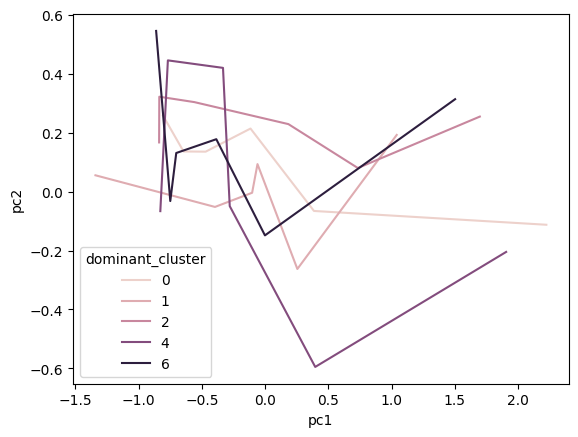

In [277]:
pc_avg = merged_df.groupby(['dominant_cluster', 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean().reset_index()
sns.lineplot(x='pc1', y='pc2', hue='dominant_cluster', data=pc_avg)
plt.show()


In [278]:
a = merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()
# Example: using your dataframe 'all_mice'
fig = go.Figure()

for cluster, df  in a.groupby(["shuffle"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
))
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC4",
    ),
    legend_title_text="shuffle"
)

fig.show()

In [279]:
a = merged_df.groupby(["dominant_cluster", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["dominant_cluster", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()
# Example: using your dataframe 'all_mice'
fig = go.Figure()

for cluster, df  in a.groupby(["dominant_cluster"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
    ))

fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
    ),
    legend_title_text="dominant_cluster"
)

fig.show()


# Features of quartiles

In [412]:
all_mice.keys()
all_mice['abs_bias'] = np.abs(all_mice['bias'])

In [413]:
all_mice.keys()

Index(['mouse_name', 'bin_frac', 'correct_easy', 'bias', 'reaction',
       'response', 'elongation', 'trial_count', 'training_days',
       'training_trials', 'time_span', 'quantile', 'abs_bias'],
      dtype='object')

<Axes: xlabel='bin_frac', ylabel='abs_bias'>

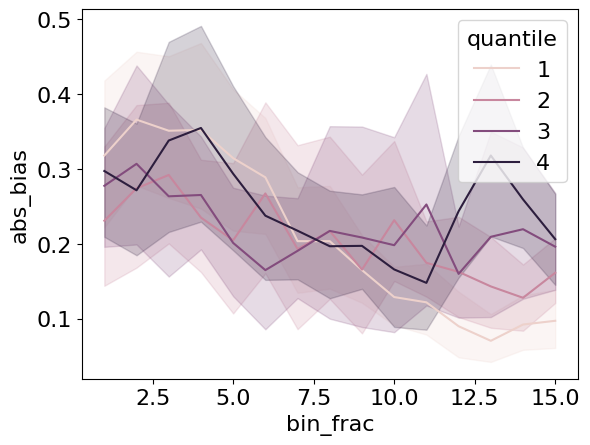

In [419]:
var = 'abs_bias'
sns.lineplot(x='bin_frac', y=var, hue='quantile', data=all_mice)


# Features of dominant clusters

In [420]:
training = training_times.merge(sankey_df[['mouse_name', 'dominant_cluster']].drop_duplicates(), on='mouse_name')
# training

<Axes: xlabel='dominant_cluster', ylabel='training_days'>

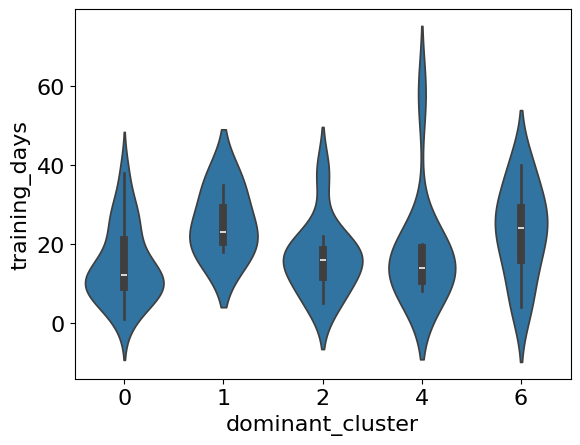

In [421]:
sns.violinplot(x='dominant_cluster', y='training_days', data=training)

# Per session

In [422]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
cluster_df = pd.read_parquet(data_path+'3_cluster_per_session_kmeans')
cluster_df = pd.read_parquet(data_path+'cluster_per_session')

In [ ]:
clusters = cluster_df.groupby(['mouse_name'])['session_cluster'].std().reset_index()
clusters.loc[clusters['session_cluster'].isna(), 'session_cluster'] = 0
merged_df = all_mice.merge(clusters, on='mouse_name')
# all_mice = all_mice.merge(cluster_df['mouse_name'], on='mouse_name')


In [ ]:
merged_df = merged_df.loc[merged_df['session_cluster']==0]
merged_df = merged_df.drop(columns='session_cluster')

In [ ]:
merged_df = merged_df.merge(cluster_df[['mouse_name', 'session_cluster']], on='mouse_name')

In [ ]:
shuffled = merged_df[['mouse_name', 'session_cluster']].drop_duplicates().reset_index()

shuffled['shuffle'] =  np.random.permutation(shuffled['session_cluster'].values)
merged_df = merged_df.merge(shuffled[['mouse_name', 'shuffle']])

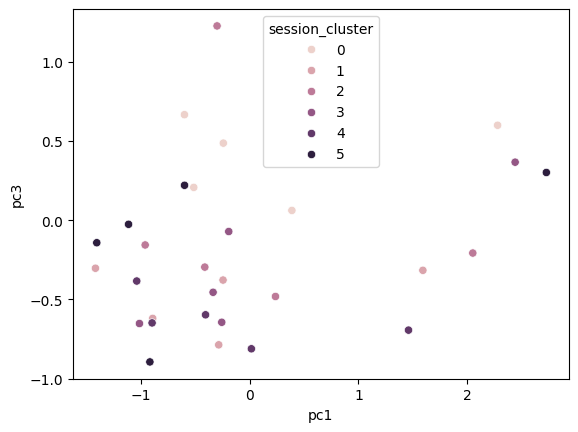

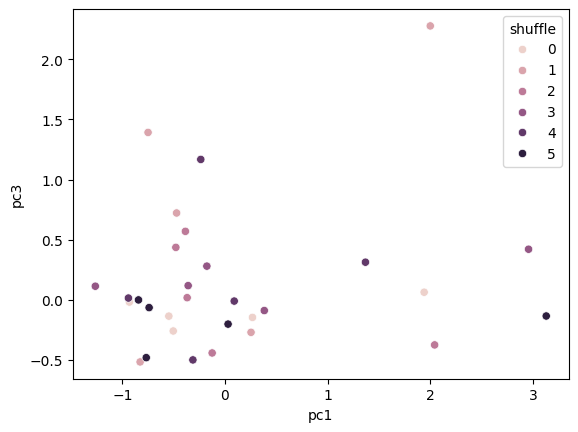

In [ ]:
pc_avg = merged_df.groupby(['session_cluster', 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean().reset_index()
sns.scatterplot(x='pc1', y='pc3', hue='session_cluster', data=pc_avg)
plt.show()

pc_avg = merged_df.groupby(['shuffle', 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean().reset_index()
sns.scatterplot(x='pc1', y='pc3', hue='shuffle', data=pc_avg)
plt.show()

In [ ]:
a = merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["shuffle", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()
# Example: using your dataframe 'all_mice'
fig = go.Figure()

for cluster, df  in a.groupby(["shuffle"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
))
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC4",
    ),
    legend_title_text="shuffle"
)

fig.show()

In [ ]:
a = merged_df.groupby(["session_cluster", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].mean()
cluster_stats =  merged_df.groupby(["session_cluster", 'bin_frac'])[['pc1', 'pc2', 'pc3', 'pc4']].sem()
cluster_stats.columns = ["pc1_err", "pc2_err",  'pc3_err', "pc4_err"]
cluster_stats = cluster_stats.reset_index()
# Example: using your dataframe 'all_mice'
fig = go.Figure()

for cluster, df  in a.groupby(["session_cluster"]):
    
    fig.add_trace(go.Scatter3d(
        x=df["pc1"],
        y=df["pc2"],
        z=df["pc3"],
        mode='lines+markers',
        name=str(cluster),
        error_x=dict(
            type="data",
            array=cluster_stats["pc1_err"],   # symmetric errors
            visible=True
        ),
        error_y=dict(
            type="data",
            array=cluster_stats["pc2_err"],
            visible=True
        ),
        error_z=dict(
            type="data",
            array=cluster_stats["pc3_err"],
            visible=True
        ),
        marker=dict(size=4),
        line=dict(width=3)
    ))

fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC4",
    ),
    legend_title_text="session_cluster"
)

fig.show()


<Axes: xlabel='bin_frac', ylabel='reaction'>

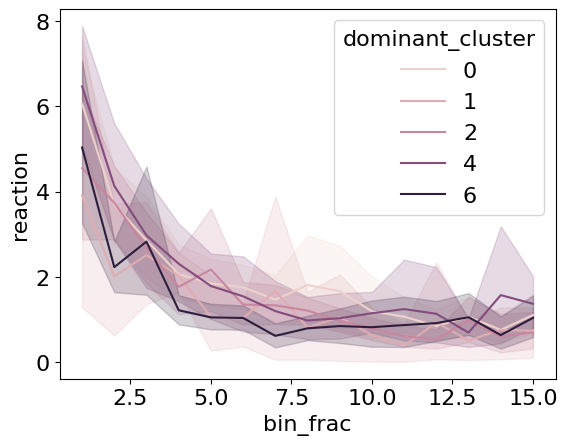

In [431]:

use_data = all_mice.merge(sankey_df[['mouse_name', 'dominant_cluster']].drop_duplicates(), on='mouse_name')
use_data = use_data.loc[use_data['dominant_cluster'].isin([0, 1, 2, 4])]


var = 'reaction'
sns.lineplot(x='bin_frac', y=var, hue='dominant_cluster', data=use_data)
# plt.ylim([0, 8])


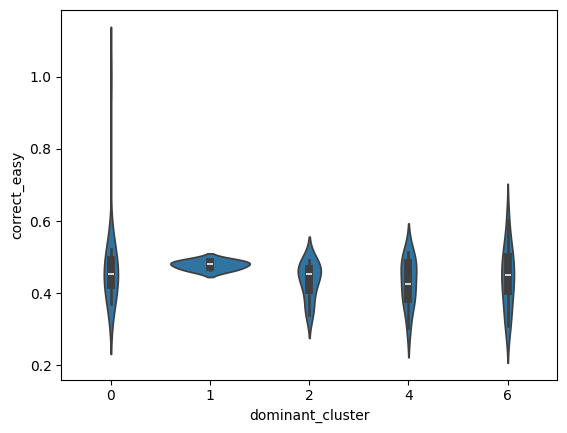

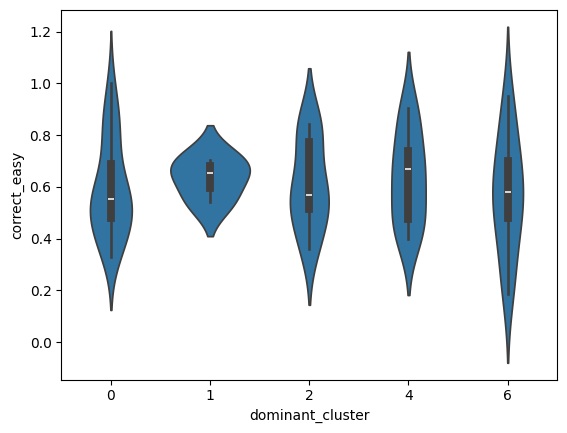

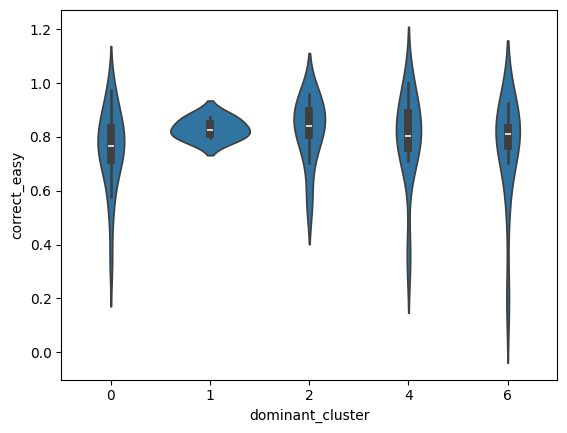

In [337]:
for i, bin in enumerate([1, 5, 10]):
    use_data = all_mice.merge(sankey_df[['mouse_name', 'dominant_cluster']].drop_duplicates(), on='mouse_name')
    use_data = use_data.loc[use_data['bin_frac']==bin]
    use_data['abs_bias'] = np.abs(use_data['bias'])
    sns.violinplot(x='dominant_cluster', y='correct_easy', data=use_data)
    plt.show()

ValueError: 'c' argument has 1425 elements, which is inconsistent with 'x' and 'y' with size 1048.

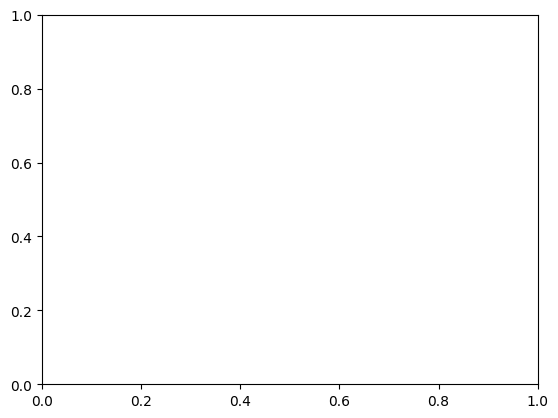

In [56]:
# color = df1['ratio'][2]
color = all_mice['training_days']
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=.8, c=color)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [80]:
training_times = pd.DataFrame(columns=['mouse_name', 'training_days', 'training_trials', 'time_span',
                                       'type', 'count', 'ratio', 'bias', 'bias_var', 'performance', 'perf_var'])

ratios = np.zeros((len(training_mice), 3))
for m, mouse_name in enumerate(training_mice):
    types = pd.DataFrame(columns=['mouse_name', 'training_days', 'training_trials', 'time_span',
                                       'type', 'count', 'ratio', 'bias', 'bias_var', 'performance', 'perf_var'], index=range(3))
    
    # Trials data
    mouse_data = pd.read_parquet(learning_data_path+'training_data_trials_'+mouse_name).drop_duplicates()

    # Save
    types['mouse_name'] = mouse_name
    types['training_days'] = len(mouse_data.session_date.unique())
    types['training_trials'] = len(mouse_data)
    types['time_span'] = (mouse_data.session_date.max() - mouse_data.session_date.min()).days
    
    session_data = get_types(mouse_data) 
    mouse_data = mouse_data.merge(session_data, on=['session_date', 'session'])
    sessions_bias = (mouse_data.groupby(['session_date', 'session'])
                                .apply(lambda x: ((x["choice"] == -1).sum() - (x["choice"] == 1).sum())/len(x))
                                .rename("bias")
                            ).reset_index()
    session_data = mouse_data.merge(sessions_bias, on=['session_date', 'session'])[['session_date', 'session', 
                                                                                    'type', 'bias', 'performance_easy']].drop_duplicates()

    for t in range(3):
        types['type'][t] = t
        types['count'][t] = len(np.unique(session_data.loc[session_data['type']==t, 'session_date']))
        types['ratio'][t] = len(np.unique(session_data.loc[session_data['type']==t, 'session_date']))/len(session_data.session_date.unique())
        types['bias'][t] = session_data.loc[session_data['type']==t, 'bias'].mean()
        types['performance'][t] =  session_data.loc[session_data['type']==t, 'performance_easy'].mean()
        types['bias_var'][t] = session_data.loc[session_data['type']==t, 'bias'].std()
        types['perf_var'][t] =  session_data.loc[session_data['type']==t, 'performance_easy'].std()  

    
        ratios[m, t] = len(np.unique(session_data.loc[session_data['type']==t, 'session_date']))/len(session_data.session_date.unique())
    training_times = pd.concat([training_times, types])


/tmp/ipykernel_17879/280615608.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: ((x["choice"] == -1).sum() - (x["choice"] == 1).sum())/len(x))
/tmp/ipykernel_17879/280615608.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer]

In [83]:
df1 = training_times.pivot(index=['mouse_name', 'training_days', 'training_trials', 'time_span'], columns='type', values=['count', 'ratio']).reset_index()

df1 = training_times.pivot(index=['mouse_name', 'training_days', 'training_trials', 'time_span'], columns='type', values=['count', 'ratio', 'bias', 'bias_var', 'performance', 'perf_var']).reset_index()

In [89]:
path = prefix + '/representation_learning_variability/paper-individuality/fig3_learning_prediction/'
training_times.to_parquet(path+'learning_metrics_',compression='gzip') 

In [90]:

# Vertices of a regular tetrahedron
T = np.array([
    [1, 0, -1/np.sqrt(2)],
    [-1, 0, -1/np.sqrt(2)],
    [0.0, 1, 1/np.sqrt(2)],
    [0.0, -1, 1/np.sqrt(2)]
])

def to_tetra_coords(p):
    """Convert (p1, p2, p3, p4) to 3D tetrahedron coordinates."""
    return p @ T  # linear combination of vertices

coords = np.array([to_tetra_coords(p) for p in ratios])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

In [91]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=coords[:, 0],
    y=coords[:, 1],
    z=coords[:, 2],
    mode='markers',
    marker=dict(size=6, 
    color = np.array(training_times[['mouse_name', 'training_days']].drop_duplicates()['training_days']),
    colorscale='Viridis',      # <<<<< CONTINUOUS COLORMAP
    colorbar=dict(title="Value"),
    showscale=True)
))

fig.update_layout(scene=dict(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Z",
))
for i in range(4):
    for j in range(i+1, 4):
        fig.add_trace(go.Scatter3d(
            x=[T[i,0], T[j,0]],
            y=[T[i,1], T[j,1]],
            z=[T[i,2], T[j,2]],
            mode='lines',
            line=dict(width=4, color='black')
        ))

fig.show()

NameError: name 'coords' is not defined

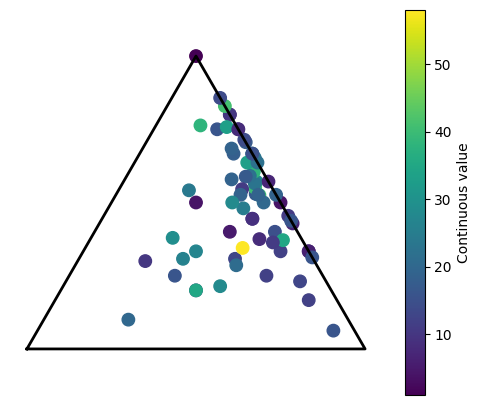

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def to_simplex_coords(p):
    """
    Convert (a, b, c) with a+b+c=1 to 2D coordinates inside an equilateral triangle.
    """
    a, b, c = p
    x = 0.5 * (2*b + c)      # b pushes right, c pushes slightly right
    y = (np.sqrt(3)/2) * c   # c pushes up
    return np.array([x, y])

coords = np.array([to_simplex_coords(p) for p in ratios])

# Continuous variable for color
values = np.array(training_times[['mouse_name', 'training_days']].drop_duplicates()['training_days'])

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

# Draw simplex outline
triangle = np.array([
    [0, 0],
    [1, 0],
    [0.5, np.sqrt(3)/2],
    [0, 0]
])
ax.plot(triangle[:,0], triangle[:,1], 'k-', lw=2)

# Scatter points
sc = ax.scatter(coords[:,0], coords[:,1], c=values, cmap='viridis', s=80)

# Add colorbar
plt.colorbar(sc, ax=ax, label='Continuous value')

ax.set_aspect('equal')
ax.set_axis_off()

plt.show()


In [93]:
import plotly.graph_objects as go

# Create trace, sizing bubbles by planet diameter
fig = go.Figure(data=go.Scatter3d(
    x = training_times['performance'],
    y = training_times['bias'],
    z = training_times['count'],
    mode = 'markers',
    marker = dict(
    color = training_times['type'])
))
fig.show()

(0.0, 1.0)

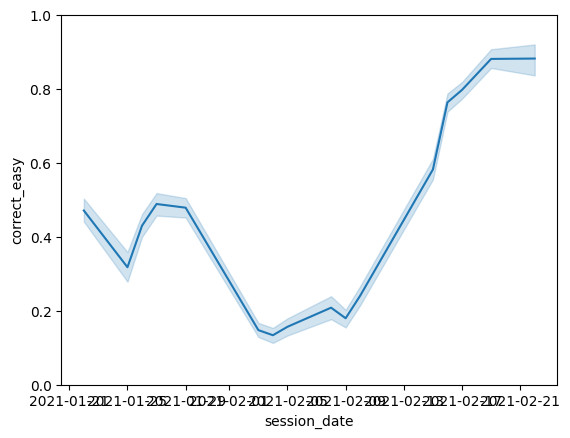

In [95]:
sns.lineplot(x='session_date', y='correct_easy', data=mouse_data)
plt.ylim([0, 1])